# Inleiding

Als onderwerp om verder uit te diepen voor dit vak heb ik gekozen voor mass spectrometry. Deels omdat het mij het meeste aansprak, maar deels ook omdat het van de mogelijke onderwerpen het meest uitdagend leek op het vlak van het nodige biologische achtergrondkennis.

Aangezien het voornaamste product van dit project de code is, is het verslag geschreven als een "Jupyter Notebook" (vroeger IPython Notebook). Dit laat toe om code, grafieken en tekst vrij te mengen. Het verslag kan met de juiste software (Jupyter en Python 3) dan ook zelf erg makkelijk 'uitgevoerd' worden (wat ik ook zou aanraden i.p.v. de pdf). De code zelf is ook vrij goed gedocumenteerd (in het Engels).

# Basiswerking

De software is geschreven als Python module. De module heet `ms` (wat niet verrassend staat voor mass spectrometry). Allereerst laten we zien dat de originele MS1 functionaliteit nog werkt (deze wordt ook gebruikt in de MS2 implementatie):

In [1]:
from ms.util import print_scores
from ms.MS1 import ProteinDB, load_peaks
ms1_db = ProteinDB()
print_scores(ms1_db.find_best_proteins('data/PMF1.txt'), normalize=False)

Loading proteins                          Done.                                         
Scoring proteins                          Done.                                         

==  ===================  =========================================================================================================================
#   score                name                                                                                                                     
==  ===================  =========================================================================================================================
 1  0.29545454545454547  sp|P07099|HYEP_HUMAN Epoxide hydrolase 1 OS=Homo sapiens GN=EPHX1 PE=1 SV=1                                              
 2   0.2857142857142857  sp|Q8NFR3|SPTSB_HUMAN Serine palmitoyltransferase small subunit B OS=Homo sapiens GN=SPTSSB PE=1 SV=1                    
 3   0.2857142857142857  sp|A0A087WSX0|LV545_HUMAN Immunoglobulin lambda variable 5-45

In wat volgt zullen we het enkel nog hebben over tandem MS. Daarvoor is het gebruik gelijkaardig, met deze keer ook aanduidingen voor target of decoy:

In [2]:
from ms.MS2 import ProteinDB2, ExpMs2Spectrum, Sequest
db = ProteinDB2(pep_tolerance=1.2)  # Peptide tolerance
scorer = Sequest(0.1)  # Tandem tolerance
sample = ExpMs2Spectrum.load_spectra('data/qExactive01819.mgf')

Loading proteins                          Done.                                         
Loading peptides                          Done.                                         
Loading proteins in reverse               Done.                                         
Loading peptides                          Done.                                         
Forming peptide list                      Done. 
Loading MS2 spectra                       Done. 


In [24]:
print_scores(db.find_best_peptides(sample[45], scorer))


==  ===================  ===========
#   score                name       
==  ===================  ===========
 1                  1.0  DECOY  HAAM
 2    0.646368275430677  TARGET FGCC
 3   0.6370173443447291  TARGET HSGE
 4   0.5445621340143759  TARGET GESH
 5   0.5356153934762075  TARGET SHGK
 6   0.5108745558178028  TARGET GPKK
 7   0.5030537704226166  TARGET GKPK
 8   0.4908160060907858  TARGET GQPK
 9  0.48901289363092004  TARGET GPQK
10  0.48679429245428235  TARGET KGPK
==  ===================  ===========



Naast dit alles kan de code ook gebruikt worden in de terminal. Zie hiervoor `python -m ms.MS1` en `python -m ms.MS2`. 

## Performantie

Ik heb mij in de eerste plaats niet al te druk gemaakt om performantie en gefocust op elegante code, maar er zijn toch een aantal zaken die een serieuze boost opleveren. Om snel alle mogelijke kandidaat peptides te vinden, maak ik gebruik van de klasse `SortedCollection` die op zijn beurt weer gebruikt maakt van de typische bisectiemethodes om elementen te vinden in een gesorteerde lijst. Het opstellen van de database is daardoor wat langer, maar eens opgesteld is het zoeken naar peptides vrij snel. Als oplossing voor de database kan die ook naar een bestand worden weggeschreven en terug uitgelezen worden:

In [4]:
db.save('/tmp/ms2.db')
db = ProteinDB2.load('/tmp/ms2.db')

Saving ProteinDB2 to /tmp/ms2.db          Done. 
Loading ProteinDB2 from /tmp/ms2.db       Done. 


De code heeft naast de standard library geen dependencies (ook niet BioPython), en werkt daardoor ook op PyPy. Bij een bestand met 1000 spectra, zonder het laden van een database, is dit 10 keer zo snel als de klassieke CPython (~44 seconden vs ~440 seconden).

# Sequest

Zoals blijkt hierboven, moet je bij het zoeken in de database een *scorer* meegeven. De voornaamste functie hierbij is `score(espec, tspec)`, die een score moet toekennen aan hoe goed het experimentele spectrum (`espec`) lijkt op het theoretische spectrum
(`tspec`). Het verschil tussen deze 2 types zit erin dat een theoretisch spectrum geen intensiteiten heeft.

Ik heb 2 manieren van scoring gemaakt: de `SharedPeaks`, en `Sequest`. De eerste is triviaal, hij telt gewoon het aantal peaks die (binnen een bepaalde tolerantie) samenvallen zonder daarbij te letten op de intensiteit van de piek. De implementatie van Sequest heeft meer voeten in de aarde. Hierbij heb ik mij vooral gebaseerd op twee papers: Eng1994 en Eng2008. Ze beschrijven beide de scorefunctie "xcorr", maar de tweede berekent die op een veel snellere manier.

## Preprocessing

De preprocessing van input bestanden (experimentele spectra) gebeurt in 2 stappen; waarvan de tweede uniek is aan de snellere xcorr (Eng2008). De eerste stap valt te bekijken als een normalisatie, de tweede als een berekening die op voorhand gedaan kan worden.

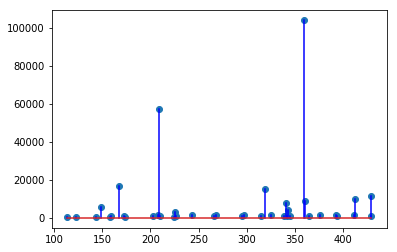

In [21]:
plt.figure(0)
sample[0].plot()

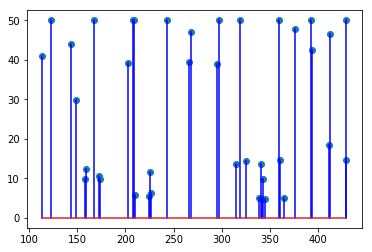

In [22]:
plt.figure(1)
pp = Sequest(0.1).preprocess_espec(sample[0])
pp.plot()

De tweede stap, het berekenen van $y' = y_0 - \Bigg( \sum \limits_{\tau=-75, \tau \neq 0}^{\tau = 75} y_{\tau} \Bigg) \Big/ 150$ is minder nuttig om te visualiseren aangezien het erg lijkt op de eerste stap met een hoop schijnbare ruis onder de x-as.

## Score
Eens we $y'$ hebben berekend, is het berekenen van de score erg eenvoudig: $xcorr = x_0 \cdot y'$. 

## Verschillen

Het grootste verschil tussen mijn implementatie en die beschreven in de papers is dat ik niet aan "unit-sized bins" doe. Dit houdt in dat men alle spectra (ook theoretische) gaat samenpakken per "unit-sized bin", dit is een m/z window van breedte 1. Als er meerdere peaks zijn voor één window, kiest men de grootste waarde (echter, bij het berekenen van $y'$ telt men gewoon op). Op deze manier wordt het spectrum (dat normaal veel fijnere data heeft over de m/z van een peak) herleid tot een lijst van een honderd- tot duizendtal getallen, waarvan velen 0 zijn. Een dot-product is dan ook makkelijk te definiëren, 

Ik heb dit echter niet gedaan. Ik behoud ten allen tijden de gedetailleerde m/z info. Het optellen van 2 spectra kan men dan gewoon zien als de 2 lijsten bijeenvoegen en hersorteren (Python's `sorted` is erg goed in deels gesorteerde lijsten). Het dot-product kunnen ook definiëren door een bepaald m/z-verschil tussen twee pieken toe te laten. De code hiervoor lijkt erg op die van het tellen van shared peaks, waarbij het toegelaten verschil de tolerantie is. Wat ik wel (optioneel) doe is in de berekening van $y'$ een aantal peaks samennemen, maar de m/z ervan is het gemiddelde van de samengenomen peaks en deze bestrijken slechts een maximum window van een tiende van de gegeven tolerantie.

# Vergelijking Crux

Om te verifiëren dat mijn algoritme werkte zoals het hoorde, wou ik deze vergelijken met een bestaande implementatie. In Eng2008 wordt Crux aangehaald als een open-source implementatie van dit algoritme, en deze heb ik dan ook gebruikt. Meer bepaald het `comet` subcommando van Crux geeft xcorr scores.

Helaas waren de meeste matches niet vergelijkbaar aan de mijne. Wat mij opviel is dat de lengte van de matches van Crux dikwijls 2 of 3 keer zo lang zijn. Het bleek dat Crux van een ander precursor gewicht uitging dan mijzelf, wat tot andere kandidaat peptides leidde. Bij de output van Crux werd ook van een zekere *assumed_charge* gegeven, en de veronderstelde massa van Crux is ongeveer gelijk aan $\text{gegeven peptide massa} * \text{assumed_charge}$. Aangezien dit totaal nieuw voor mij was heb ik hier verder geen rekening mee gehouden, en mij gefocust op spectra waarvan de *assumed_charge* 1 is.

Een voorbeeld hiervan is het 252e spectrum (wat de 557e scan in het experiment zou zijn geweest) in het gegeven inputbestand. Crux geeft hiervoor de volgende matches:

  - `THSGRK`: 0.511
  - `THSALR`: 0.446
  - `SFSGRK`: 0.459
  - `KKALLL`: 0.442
  - `HTLCR`: 0.440

Mijn eigen matches zijn als volgt:

In [18]:
scorer = Sequest(0.2)
scan_557 = sample[252]
pp = scorer.preprocess_espec(scan_557)
print_scores(db.find_best_peptides(pp, scorer, amount=10))


==  ==================  =============
#   score               name         
==  ==================  =============
 1                 1.0  TARGET THSGRK
 2  0.9691707693218686  TARGET THSVNK
 3  0.7972702965562524  TARGET THWNK 
 4  0.7538264687530879  DECOY  THAQTK
 5  0.7473279809029156  DECOY  HTVNSK
 6   0.746670609127178  TARGET THVSNK
 7    0.74065054356629  TARGET THATQK
 8  0.7350387461210582  TARGET THNGEK
 9  0.7312553638520222  DECOY  THSPSR
10  0.6028465527327648  TARGET SHTGQR
==  ==================  =============



Ik moet toegeven dat ik een beperkt met de parameters heb moeten spelen (tolerantie van 0.2 ipv 0.1) voor ik, net zoals Crux, hetzelfde resultaat bekwam als topscore. (Het spectrum zelf is echter willekeurig gekozen.) Deze match ziet er als volgt uit:

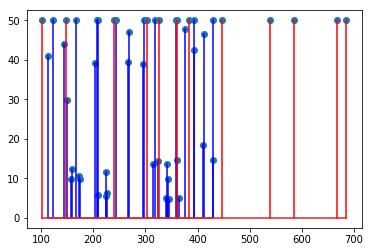

In [23]:
from ms.MS2 import TheoMs2Spectrum
plt.figure(4)
pp.plot('blue')
TheoMs2Spectrum.from_sequence('THSGRK').plot('red')

Ook al gaat het hier maar om één voorbeeld, ik beschouw dit als voldoende bewijs dat mijn implementatie een redelijke implementatie is van Sequest. Mochten er ergens programmeerfouten in geslopen zijn, zou dit toch een sterk anders resultaat geven. Kwestie van accuraatheid en andere meer biologische aspecten zijn er natuurlijk nog tal van mogelijkheden, mogelijks te beginnen bij iets equivalent aan de *assumed_charge*.